# Trash

In [ ]:
G = np.hypot(mysobel_img_x, mysobel_img_y)
G = G / G.max() *255

theta = np.arctan2(mysobel_img_y, mysobel_img_x)

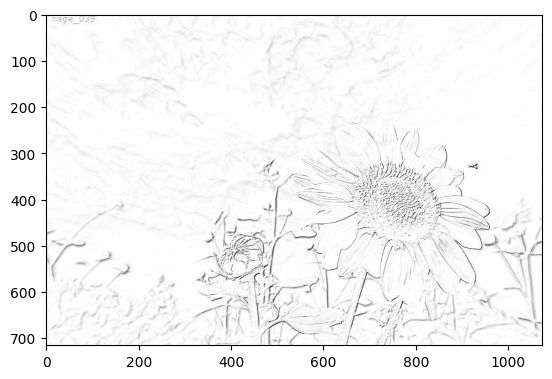

In [ ]:
plt.imshow(G, cmap='Greys')

In [ ]:
m, n = theta.shape

threshold = 1-np.cos(67.5/180*np.pi)
img_suppressed = np.zeros_like(img)
for i in range(m):
    for j in range(n):
        th = theta[i, j]

        # calculates the cartesian coordinates from theta
        x = np.cos(th)
        y = np.sin(th)

        # step is just 0 or 1
        sx = int(x + threshold* ((-1)**(y<0))) # step in the direction of x
        sy = int(y + threshold) # step in the direction of y

        try:
            q = theta[i+sy, j+sx]
        except:
            pass
        r = theta[i-sy, j-sx]

        g = G[i, j]

        if g >= max(q, r, g):
            img_suppressed[i, j] = g

IndexError: index 1074 is out of bounds for axis 1 with size 1074

In [ ]:
theta = 67.5

t = np.cos(theta/180*np.pi)

x = int(t + (1-np.cos(67.5/180*np.pi))*((-1)**(t<0)))
y = int((np.sin(theta/180*np.pi)) + 1-np.cos(67.5/180*np.pi))

print(y, x)

1 1


# Test

In [ ]:
class CannyFilter:
    def mysobel_filters(self, img, ksize):
        opensobel_img_x = cv2.Sobel(img, -1, 1, 0, ksize=ksize, borderType=cv2.BORDER_CONSTANT)
        opensobel_img_y = cv2.Sobel(img, -1, 0, 1, ksize=ksize, borderType=cv2.BORDER_CONSTANT)

        G = np.hypot(opensobel_img_x, opensobel_img_y)
        G = (G / G.max() *255).astype(np.uint8)

        theta = np.arctan2(mysobel_img_y, mysobel_img_x)

        return G, theta

    def mynon_max_suppression(self, G, theta):
        m, n = theta.shape
        theta[theta<0] += np.pi
        theta[theta>np.pi] -= np.pi
        threshold = 1-np.cos((67.5/180)*np.pi)
        img_suppressed = np.zeros_like(G)

        # G = np.pad(G, 1)

        for i in range(1, m-1):
            for j in range(1, n-1):
                th = theta[i, j]

                # calculates the cartesian coordinates from theta
                x = np.cos(th)
                y = np.sin(th)

                # step is just 0 or 1
                sx = int(x + threshold* ((-1)**(x<0))) # step in the direction of x
                sy = int(y + threshold) # step in the direction of y

                q = G[i+sy, j-sx]
                r = G[i-sy, j+sx]


                g = G[i, j]

                if g == max(q, r, g):
                    img_suppressed[i, j] = g
        return img_suppressed

    def mythreshold(self, img_suppressed, low=0.1, high=0.5):    
        res = np.zeros_like(img_suppressed)
        
        high = high*img_suppressed.max()
        low = low*img_suppressed.max()
        
        high_value = 255
        weak_value = 125

        res[img_suppressed>=high] = high_value
        res[(img_suppressed>=low) & (img_suppressed<high)] = weak_value

        return res, weak_value, high_value

    def myHysteresis(self, img, weak_value, high_value):
        m, n = img.shape
        pw = 1

        filter = np.ones((3, 3))*high_value
        filter[1, 1] = 0

        for i in range(1, m-1):
            for j in range(1, n-1):
                if img[i, j] == weak_value:
                    slice = img[i-pw:i+pw+1, j-pw:j+pw+1]
                    istrong = np.any(slice == filter)
                    img[i-pw, j-pw] = istrong*high_value

        return img


    def detect(self, img, threshold1, threshold2):
        b, g, r = img.transpose(2, 0, 1)
        img = (0.299*r + 0.587*g + 0.114*b).reshape(*img.shape[:2], 1)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = GaussianFilter(img, ksize=(0, 0), sigma=1)()
        opensobel_img_x = SobelFilter(img, 1, 0)()
        opensobel_img_y = SobelFilter(img, 0, 1)()

        G = np.hypot(opensobel_img_x, opensobel_img_y)
        G = (G / G.max() *255).astype(np.uint8)

        theta = np.arctan2(mysobel_img_y, mysobel_img_x)

        img_suppressed = self.mynon_max_suppression(G, theta)
        img_threshold, high_value, weak_value = self.mythreshold(img_suppressed, threshold1, threshold2)
        img_hysteresis = self.myHysteresis(img_threshold, high_value, weak_value)
        return img_hysteresis


# Trash

In [ ]:
# class helper():
#     def _weighted_sum(img, filter):
#         weighted_sum = (img*filter).sum()
#         return int(weighted_sum+0.5)

    
#     def convolute(img, filter):

#         if len(img.shape) == len(filter.shape):
#             try:
#                 assert img.shape[2] == filter.shape[2], "# channels of image and filter must be the same"
#             except IndexError:
#                 img = img[:, :, np.newaxis]
#                 filter = filter[:, :, np.newaxis]
#         else:
#             raise ValueError("# channels of image and filter must be the same")

#         pw = filter.shape[0]//2

#         pad_width = ((pw, pw), (pw, pw), (0, 0))
#         padded_img = np.pad(img, pad_width)

#         new_img = np.zeros(img.shape)
#         h, w = padded_img.shape[:2]
#         for i in range(pw, h-pw):
#             for j in range(pw, w-pw):
#                 slice = padded_img[i-pw:i+pw+1, j-pw:j+pw+1]
#                 weighted_sum = helper._weighted_sum(slice, filter)
#                 new_img[i-pw, j-pw] = weighted_sum
        
#         new_img = np.round(np.clip(new_img, 0, 255)).astype(np.uint8).squeeze()
#         return new_img

# class GaussianFilter():
#     def __init__(self, src, ksize, sigma):

#         if 0 in ksize:
#             size = 2 * int(4 * sigma + 0.5) + 1
#             self.ksize = (size, size)
#         else:
#             self.ksize = ksize

#         self.src = src
#         self.sigma = sigma

#     def __call__(self):
#         self.filter = self.gaussian_filter(self.ksize, self.sigma)
#         img_covolved = self.apply_filter_over_channels(self.src, self.filter)
#         return img_covolved

#     def gaussian_function(self, sigma, x, y):
#         t1 = 1/(2*np.pi*(sigma**2))
#         t2 = np.exp(-(x**2+y**2)/(2* sigma**2))
#         G = t1*t2
#         return G

#     def gaussian_filter(self, shape, sigma):
#         m, n = shape
#         m_h, n_h = m//2, n//2

#         filter = np.zeros(shape)
#         for i in range(-m_h, m_h+1):
#             for j in range(-n_h, n_h+1):
#                 filter[i+m_h, j+n_h] = self.gaussian_function(sigma, i, j)
#         filter /= filter.sum() 
#         return filter
    
#     def apply_filter_over_channels(self, img, filter):
#         img_covolved = np.zeros_like(img)
#         for i, channel in enumerate(img.transpose(2, 0, 1)):
#             img_covolved[:, :, i] = helper.convolute(channel, filter)
            
#         return img_covolved

# class SobelFilter():
#     def __init__(self, src, dx, dy, ksize=(3, 3)):
#         kx = np.array([[-1, 0, 1],
#                        [-2, 0, 2],
#                        [-1, 0, 1]], np.float32)
#         ky = kx.T
        
#         kxy = kx * ky

#         if dx == 1 and dy==0: k=kx
#         elif dx == 0 and dy==1: k=ky
#         elif dx == 1 and dy==1: k=kxy
#         else: raise Exception('(dx, dy) must be (0, 1), (1, 0) or (1, 1) till now')

#         self.src = src
#         self.k = k

#     def __call__(self):
#         sobel_img = helper.convolute(self.src, self.k)
#         return sobel_img

In [ ]:
from scipy.ndimage import convolve

class CannyEdgeDetector:
    @staticmethod
    def gaussian_blur(img, size, sigma):
        size = int(size) // 2
        x, y = np.mgrid[-size:size+1, -size:size+1]
        normal = 1 / (2.0 * np.pi * sigma**2)
        g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal

        img_smoothed = convolve(img, g)

        return img_smoothed

    @staticmethod
    def sobel_filters(img):
        Kx = np.array([[-1, 0, 1],
                       [-2, 0, 2],
                       [-1, 0, 1]], np.float32)
        Ky = np.array([[1, 2, 1],
                       [0, 0, 0], 
                       [-1,-2,-1]], np.float32)

        Ix = convolve(img, Kx)
        Iy = convolve(img, Ky)

        G = np.hypot(Ix, Iy)
        G = G / G.max() * 255
        theta = np.arctan2(Iy, Ix)
        return (G, theta)
    
    @staticmethod
    def non_max_suppression(G, theta):
        m, n = G.shape
        angle = theta * 180. / np.pi
        angle[theta<0] += np.pi
        angle[theta>180] -= 180
        img_suppressed = np.zeros_like(G)

        for i in range(1, m-1):
            for j in range(1, n-1):

                #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = G[i, j+1]
                    r = G[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = G[i+1, j-1]
                    r = G[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = G[i+1, j]
                    r = G[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = G[i-1, j-1]
                    r = G[i+1, j+1]
                else: print(f"#############{angle[i,j]}###################")

                g = G[i, j]
                if g == max(q, r, g):
                    img_suppressed[i, j] = g

        return img_suppressed
    
    @staticmethod
    def threshold(img, highThreshold=200, lowThreshold=100, weak_pixel=125, strong_pixel=255):

        # highThreshold = 200 #  img.max() * self.highThreshold;
        # lowThreshold = 100 # highThreshold * self.lowThreshold;

        M, N = img.shape
        res = np.zeros((M,N), dtype=np.int32)

        weak = np.int32(weak_pixel)
        strong = np.int32(strong_pixel)

        strong_i, strong_j = np.where(img >= highThreshold)
        zeros_i, zeros_j = np.where(img < lowThreshold)

        weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

        res[strong_i, strong_j] = strong
        res[weak_i, weak_j] = weak

        return (res)
    
    @staticmethod
    def hysteresis(img, weak, strong):

        M, N = img.shape

        for i in range(1, M-1):
            for j in range(1, N-1):
                if (img[i,j] == weak):
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0

        return img

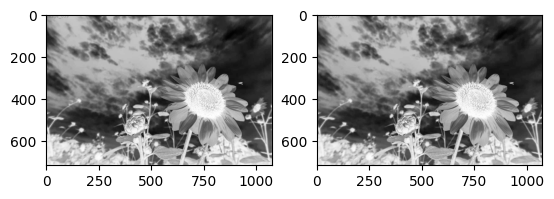

In [ ]:
myImg_blur = cv2.GaussianBlur(img, ksize =(3, 3), sigmaX=1, borderType=cv2.BORDER_CONSTANT)
ttImg_blur = CannyEdgeDetector.gaussian_blur(img, 3, 1)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(myImg_blur, cmap="Greys")
ax2.imshow(ttImg_blur, cmap="Greys")

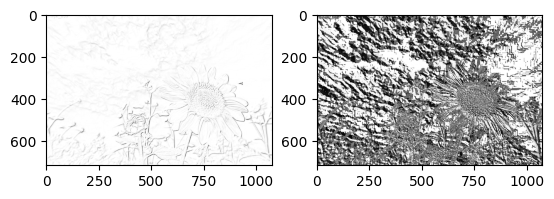

In [ ]:
myG_blur_sobel, myTheta_blur_sobel = mysobel_filters(myImg_blur, 3)
ttG_blur_sobel, ttTheta_blur_sobel = CannyEdgeDetector.sobel_filters(ttImg_blur)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(myG_blur_sobel, cmap="Greys")
ax2.imshow(ttG_blur_sobel, cmap="Greys")

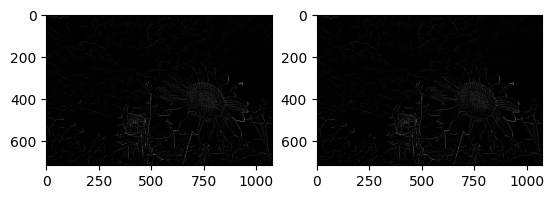

In [ ]:
myG_blur_sobel_supp = mynon_max_suppression(myG_blur_sobel, myTheta_blur_sobel)
ttG_blur_sobel_supp = CannyEdgeDetector.non_max_suppression(myG_blur_sobel, myTheta_blur_sobel)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(~myG_blur_sobel_supp, cmap="Greys")
ax2.imshow(~ttG_blur_sobel_supp, cmap="Greys")

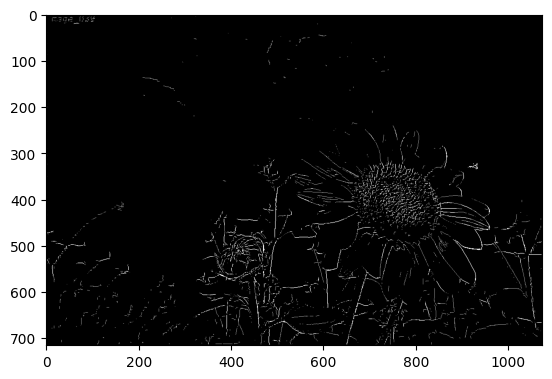

In [ ]:
myG_blur_sobel_suppth, w, s = mythreshold(myG_blur_sobel_supp, 50, 100)
# ttG_blur_sobel_suppth = CannyEdgeDetector.threshold(myG_blur_sobel_supp, 100, 50)

# fig, (ax1, ax2) = plt.subplots(1, 2)
plt.imshow(~myG_blur_sobel_suppth, cmap="Greys")
# ax2.imshow(~ttG_blur_sobel_suppth, cmap="Greys")

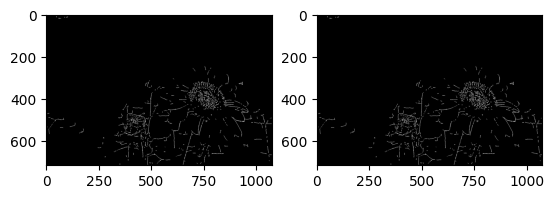

In [ ]:
myG_blur_sobel_suppth_H = myHysteresis(myG_blur_sobel_suppth, w, s)
ttG_blur_sobel_suppth_H = CannyEdgeDetector.hysteresis(myG_blur_sobel_suppth, w, s)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(~myG_blur_sobel_suppth_H, cmap="Greys")
ax2.imshow(~ttG_blur_sobel_suppth_H, cmap="Greys")

In [ ]:
np.sum(myG_blur_sobel_suppth_H != ttG_blur_sobel_suppth_H)

1345

In [ ]:
tempImg = myG_blur_sobel_suppth
high_value, weak_value = 255, 125

m, n = tempImg.shape
pw = 1
img_hysteresis = np.zeros_like(tempImg)
tempImg = np.pad(tempImg, pw)

filter = np.ones((3, 3))*high_value
filter[1, 1] = 0
for i in range(1, m):
    for j in range(1, n):
        if tempImg[i, j] == weak_value:
            slice = tempImg[i-pw:i+pw+1, j-pw:j+pw+1]
            istrong = np.any(slice == filter)
            if istrong:
                print(f"slice: \n{slice}")
                print(f"filter: \n{filter}")
                print(f"istrong: {istrong}\n")
            img_hysteresis[i, j] = istrong*high_value

In [ ]:

def mycanny(img, threshold1, threshold2):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img, ksize=(0, 0), sigmaX=1)
    opensobel_img_x = cv2.Sobel(img, -1, 1, 0, ksize=3, borderType=cv2.BORDER_CONSTANT)
    opensobel_img_y = cv2.Sobel(img, -1, 0, 1, ksize=3, borderType=cv2.BORDER_CONSTANT)

    mag = np.hypot(opensobel_img_x, opensobel_img_y)
    mag = (mag / mag.max() *255).astype(np.uint8)

    theta = np.arctan2(mysobel_img_y, mysobel_img_x)

    img_suppressed = non_max_suppression(mag, theta)
    img_threshold, high_value, weak_value = threshold(img_suppressed, threshold1, threshold2)
    img_hysteresis = Hysteresis(img_threshold, high_value, weak_value)
    return img_hysteresis


In [ ]:
theta = 67.5

t = np.cos(theta/180*np.pi)

x = int(t + (1-np.cos(67.5/180*np.pi))*((-1)**(t<0)))
y = int((np.sin(theta/180*np.pi)) + 1-np.cos(67.5/180*np.pi))

print(y, x)

1 1


In [ ]:
    # def mysobel_filters(self, img, ksize):
    #     opensobel_img_x = cv2.Sobel(img, -1, 1, 0, ksize=ksize, borderType=cv2.BORDER_CONSTANT)
    #     opensobel_img_y = cv2.Sobel(img, -1, 0, 1, ksize=ksize, borderType=cv2.BORDER_CONSTANT)

    #     G = np.hypot(opensobel_img_x, opensobel_img_y)
    #     G = (G / G.max() *255).astype(np.uint8)

    #     theta = np.arctan2(mysobel_img_y, mysobel_img_x)

    #     return G, theta